C:\Users\rapha\AppData\Local\Temp\ipykernel_2156\1283174289.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  C09CA01 = C09CA01.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)


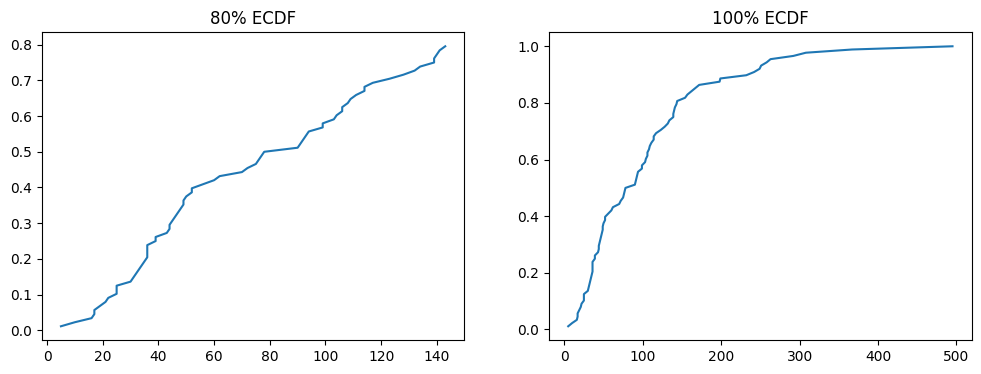

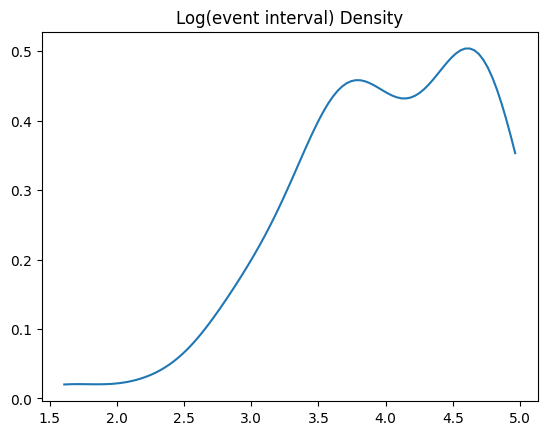

C:\Users\rapha\AppData\Local\Temp\ipykernel_2156\1283174289.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  C09CA01 = C09CA01.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)


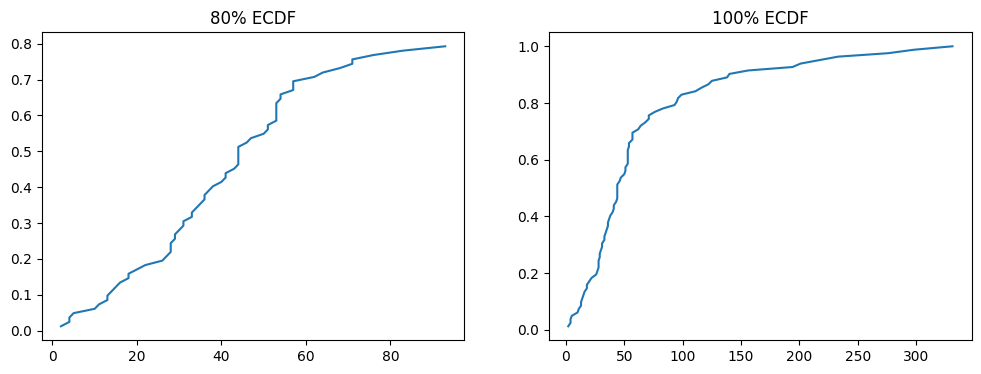

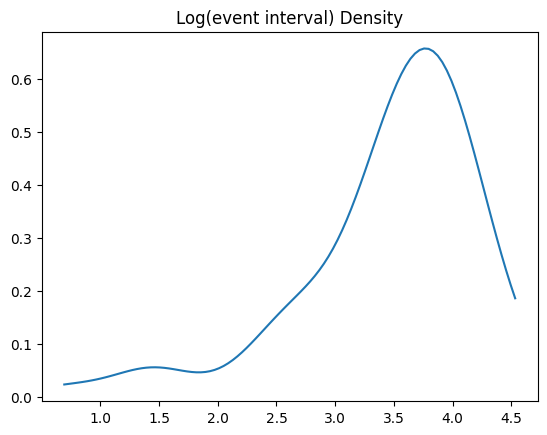

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load dataset from CSV
med_events = pd.read_csv("../data/med_events.csv")  # Adjust path if necessary
med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
med_events["eksd"] = pd.to_datetime(med_events["eksd"])

def see(arg1):
    C09CA01 = med_events[med_events["ATC"] == arg1].copy()
    if C09CA01.empty:
        print(f"Warning: No data found for {arg1}.")
        return pd.DataFrame(columns=["pnr", "median", "cluster"])
    
    C09CA01.sort_values(by=["pnr", "eksd"], inplace=True)
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01.dropna(subset=["prev_eksd"], inplace=True)
    if C09CA01.empty:
        print(f"Warning: No valid previous dates for {arg1}.")
        return pd.DataFrame(columns=["pnr", "median", "cluster"])
    
    C09CA01 = C09CA01.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days
    
    # Empirical CDF
    x = np.sort(C09CA01["event_interval"].dropna().values)
    y = np.arange(1, len(x) + 1) / len(x)
    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]
    
    if dfper.empty:
        print(f"Warning: No valid data for {arg1}. Skipping further analysis.")
        return pd.DataFrame(columns=["pnr", "median", "cluster"])
    
    ni = dfper["x"].max()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(dfper["x"], dfper["y"], label="80% ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label="100% ECDF")
    plt.title("100% ECDF")
    plt.show()
    
    # Density plot (Ensure only valid values are used)
    filtered_intervals = C09CA01[C09CA01["event_interval"] <= ni]["event_interval"]
    filtered_intervals = filtered_intervals[filtered_intervals > 0].dropna()
    
    if filtered_intervals.empty:
        print(f"Warning: No valid log intervals for {arg1}. Skipping KDE plot.")
        return pd.DataFrame(columns=["pnr", "median", "cluster"])
    
    log_intervals = np.log(filtered_intervals)
    
    density = gaussian_kde(log_intervals)
    xs = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    plt.plot(xs, density(xs))
    plt.title("Log(event interval) Density")
    plt.show()
    
    # Clustering
    scaled_data = StandardScaler().fit_transform(log_intervals.values.reshape(-1, 1))
    
    silhouette_scores = []
    for k in range(2, min(10, len(scaled_data))):  # Prevents error if data is too small
        try:
            labels = KMeans(n_clusters=k, random_state=1234).fit_predict(scaled_data)
            silhouette_scores.append(silhouette_score(scaled_data, labels))
        except:
            silhouette_scores.append(-1)  # Skip invalid cases

    if not silhouette_scores or max(silhouette_scores) == -1:
        print(f"Warning: No valid clusters found for {arg1}.")
        return pd.DataFrame(columns=["pnr", "median", "cluster"])

    best_k = np.argmax(silhouette_scores) + 2
    
    kmeans = KMeans(n_clusters=best_k, random_state=1234).fit(dfper[["x"]])
    dfper["cluster"] = kmeans.labels_
    
    cluster_summary = dfper.groupby("cluster")["x"].agg(["min", "max", "median"]).reset_index()
    cluster_summary[["min", "max", "median"]] = np.exp(cluster_summary[["min", "max", "median"]])
    
    results = C09CA01.merge(cluster_summary, how="cross")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]
    results = results[["pnr", "median", "cluster"]]
    
    return results

# Run the analysis for two different medications
medA = see("medA")
medB = see("medB")

def see_assumption(data):
    if data.empty or not {"pnr", "eksd"}.issubset(data.columns):
        print("Warning: No valid data or missing columns for assumption check.")
        return

    data.sort_values(by=["pnr", "eksd"], inplace=True)
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    data.dropna(subset=["prev_eksd"], inplace=True)
    if data.empty:
        print("Warning: No valid previous dates for assumption check.")
        return
    
    data["Duration"] = (data["eksd"] - data["prev_eksd"]).dt.days
    data["p_number"] = data.groupby("pnr").cumcount() + 1

    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data["p_number"].astype(str), y=data["Duration"])
    plt.title("Prescription Interval Distribution")
    plt.show()

    return data

see_assumption(medA)
see_assumption(medB)